# 2. Nettoyage des données

## Variables d'environnement

In [1]:
TWEETS_PATH = 'data/training.1600000.processed.noemoticon.csv'
OUTPUT_PATH = 'data/cleaned_tweets.parquet'

## Imports des dépendances

In [2]:
import os
import pandas as pd
import re
import nltk
from pandarallel import pandarallel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

## Configuration des dépendances

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
os.environ["TF_USE_LEGACY_KERAS"] = "1"
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /home/noah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/noah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/noah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Import du jeu de données

In [4]:
columns_names = ['target', 'id', 'date', 'flag', 'user', 'text']
tweets_df = pd.read_csv(TWEETS_PATH, encoding='ISO-8859-1', names=columns_names)

del columns_names

tweets_df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Nettoyage des variables inutiles
Seul deux colonnes nous intéresse ici :
- target : 0 pour les tweets négatifs et 4 pour les tweets positifs
- text : le tweet

In [5]:
tweets_df = tweets_df[['target', 'text']]

## Nettoyage de la target
Par soucis de lisibilité, nous allons remplacer les valeurs de target par 0 et 1 : 0 -> négatif, 4 -> positif

In [6]:
tweets_df['target'] = tweets_df['target'].replace(4, 1)
print(f"Valeurs uniques de target : {tweets_df['target'].unique()}")

Valeurs uniques de target : [0 1]


## Nettoyage du texte (tweets)

In [7]:
words_to_keep = {
    'ok', 'okay',
    'not', 'no', 'nor', 'but',
    'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
    'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
    'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
}

contractions_dict = {
    "i'm": "i am",
    "can't": "cannot",
    "won't": "will not",
    "it's": "it is",
    "don't": "do not"
}

happy_pattern = r'(?<!\S)(?:[:;=8][-]?[\)D\]}pP3]|<3)(?!\S)' # POSITIFS : :) :-) :D :] =] ;) :p :P :3 <3
sad_pattern = r'(?<!\S)[:;=8][-]?[\(\[/{|c](?!\S)' # NEGATIFS : :( :-( :[ =[ :/ :{ :| :c

stop_words = set(stopwords.words('english'))
stop_words = stop_words - words_to_keep
punctuation = punctuation + "’"
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def clean_text(text, processing = "lemmatizer"):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    text = re.sub(happy_pattern, 'tokensmileyhappy', text)
    text = re.sub(sad_pattern, 'tokensmileysad', text)

    text = text.lower()

    for key, value in contractions_dict.items():
        text = text.replace(key, value)

    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.replace("’", '')

    if processing == "stemmer":
        processor = stemmer.stem
    else:
        processor = lemmatizer.lemmatize

    tokens = [
        processor(word)
        for word in word_tokenize(text)
        if word not in stop_words
        and not word.isdigit() # Retirer les mots composés uniquement de chiffres
        and (len(word) > 2 or word in words_to_keep) # Retirer les mots de 2 lettres ou moins
    ]

    return tokens

In [9]:
def clean_text_bert(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    text = re.sub(happy_pattern, ' tokensmileyhappy ', text)
    text = re.sub(sad_pattern, ' tokensmileysad ', text)

    for key, value in contractions_dict.items():
        text = text.replace(key, value)

    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
tweets_df['text_lemmatized'] = tweets_df['text'].parallel_apply(lambda x: clean_text(x, processing="lemmatizer"))
tweets_df['text_stemmed'] = tweets_df['text'].parallel_apply(lambda x: clean_text(x, processing="stemmer"))
tweets_df['bert_text'] = tweets_df['text'].parallel_apply(clean_text_bert)

In [11]:
tweets_df['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [12]:
tweets_df['text_lemmatized'].head()

0    [awww, thats, bummer, shoulda, got, david, car...
1    [upset, not, update, facebook, texting, might,...
2    [dived, many, time, ball, managed, save, rest,...
3               [whole, body, feel, itchy, like, fire]
4                   [no, not, behaving, mad, not, see]
Name: text_lemmatized, dtype: object

In [13]:
tweets_df['text_stemmed'].head()

0    [awww, that, bummer, shoulda, got, david, carr...
1    [upset, not, updat, facebook, text, might, cri...
2    [dive, mani, time, ball, manag, save, rest, bo...
3               [whole, bodi, feel, itchi, like, fire]
4                      [no, not, behav, mad, not, see]
Name: text_stemmed, dtype: object

## Renommage des colonnes

In [14]:
tweets_df = tweets_df.rename(columns={'text_lemmatized': 'tokens_lemmatized', 'text_stemmed': 'tokens_stemmed', 'text': 'original_text'})

In [15]:
tweets_df.head()

,target,original_text,tokens_lemmatized,tokens_stemmed,bert_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...","[awww, that, bummer, shoulda, got, david, carr...","- awww, that's a bummer. you shoulda got david..."
1,0,is upset that he can't update his Facebook by ...,"[upset, not, update, facebook, texting, might,...","[upset, not, updat, facebook, text, might, cri...",is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,...","[dive, mani, time, ball, manag, save, rest, bo...",i dived many times for the ball. managed to sa...
3,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","[no, not, behaving, mad, not, see]","[no, not, behav, mad, not, see]","no, it is not behaving at all. i am mad. why a..."


## Assemblage des tokens

In [16]:
tweets_df['text_lemmatized'] = tweets_df['tokens_lemmatized'].parallel_apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
tweets_df['text_stemmed'] = tweets_df['tokens_stemmed'].parallel_apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [17]:
tweets_df.head()

,target,original_text,tokens_lemmatized,tokens_stemmed,bert_text,text_lemmatized,text_stemmed
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...","[awww, that, bummer, shoulda, got, david, carr...","- awww, that's a bummer. you shoulda got david...",awww thats bummer shoulda got david carr third...,awww that bummer shoulda got david carr third ...
1,0,is upset that he can't update his Facebook by ...,"[upset, not, update, facebook, texting, might,...","[upset, not, updat, facebook, text, might, cri...",is upset that he cannot update his facebook by...,upset not update facebook texting might cry re...,upset not updat facebook text might cri result...
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,...","[dive, mani, time, ball, manag, save, rest, bo...",i dived many times for the ball. managed to sa...,dived many time ball managed save rest bound,dive mani time ball manag save rest bound
3,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",my whole body feels itchy and like its on fire,whole body feel itchy like fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....","[no, not, behaving, mad, not, see]","[no, not, behav, mad, not, see]","no, it is not behaving at all. i am mad. why a...",no not behaving mad not see,no not behav mad not see


## WordCloud

In [18]:
def display_words_frequency(dataframe, target = 'all', with_barplot = True):
    if target == 'all':
        tweets_list = dataframe['tokens_lemmatized']
    elif target == 'negative':
        tweets_list = dataframe[dataframe['target'] == 0]['tokens_lemmatized']
    else:
        tweets_list = dataframe[dataframe['target'] == 1]['tokens_lemmatized']

    tweets_text = " ".join(tweets_list.apply(' '.join))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tweets_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Mots fréquents - Tweets {target}')
    plt.show()

    if with_barplot:
        words = tweets_text.split()
        word_freq = Counter(words)

        most_common = word_freq.most_common(20)
        words = [word for word, _ in most_common]
        counts = [count for _, count in most_common]

        plt.figure(figsize=(12, 6))
        sns.barplot(x=counts, y=words, hue=words, legend=False, palette='viridis')
        plt.title(f'20 mots les plus fréquents - Tweets {target}')
        plt.xlabel('Fréquence')
        plt.ylabel('Mots')
        plt.tight_layout()
        plt.show()

        del words
        del word_freq
        del most_common
        del counts

    del tweets_text
    del wordcloud

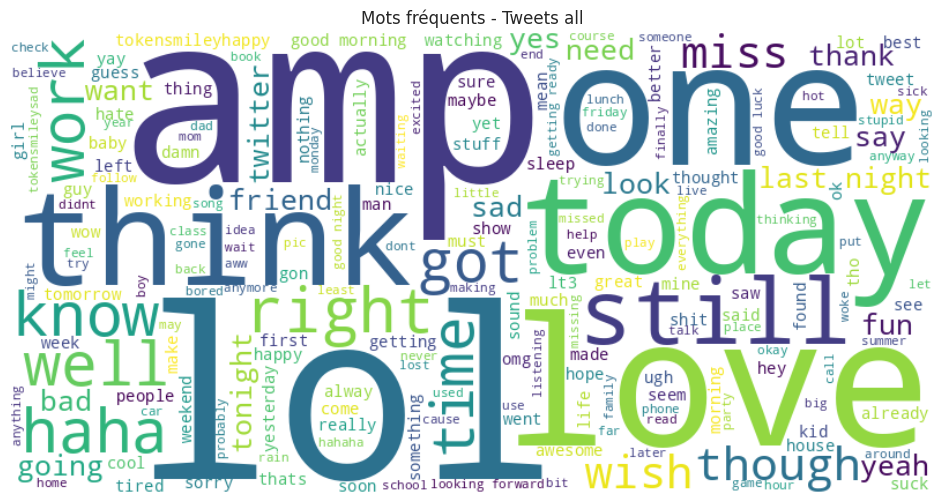

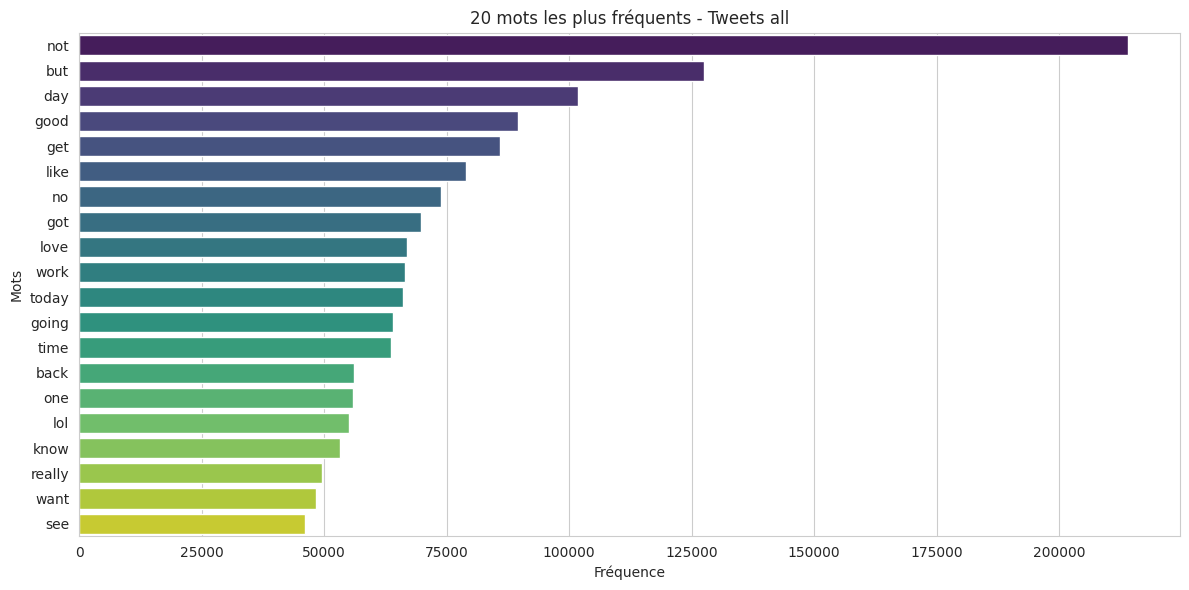

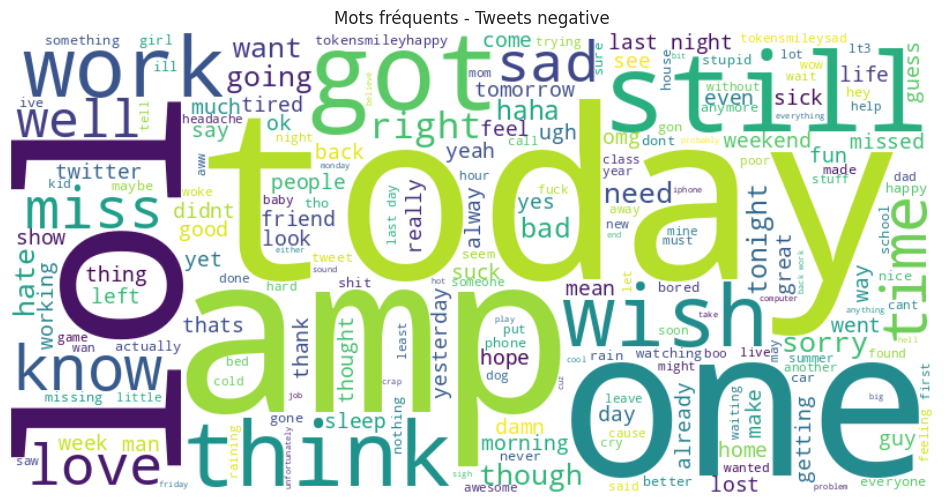

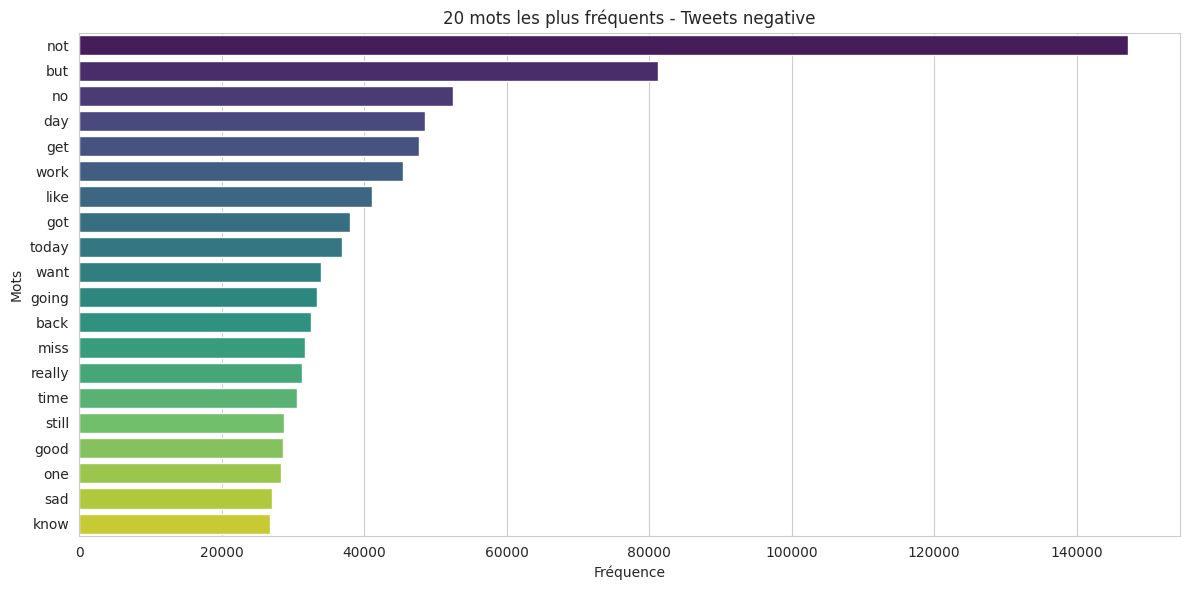

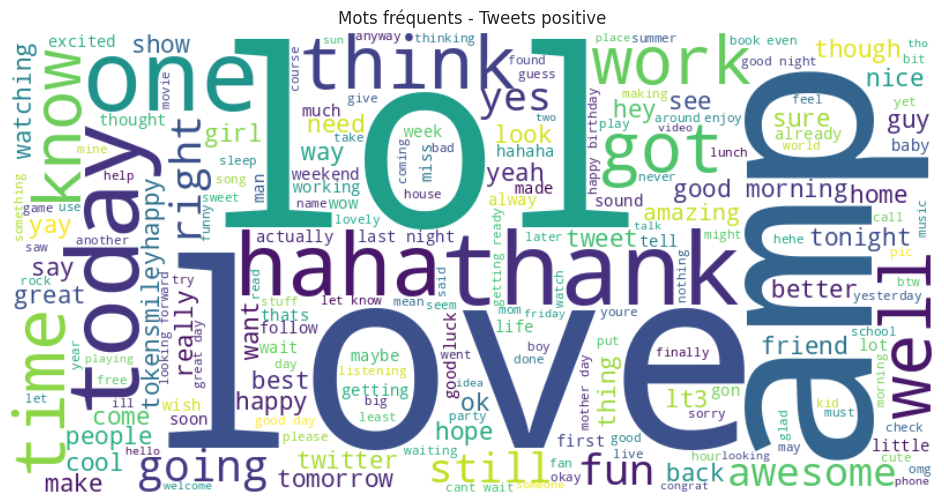

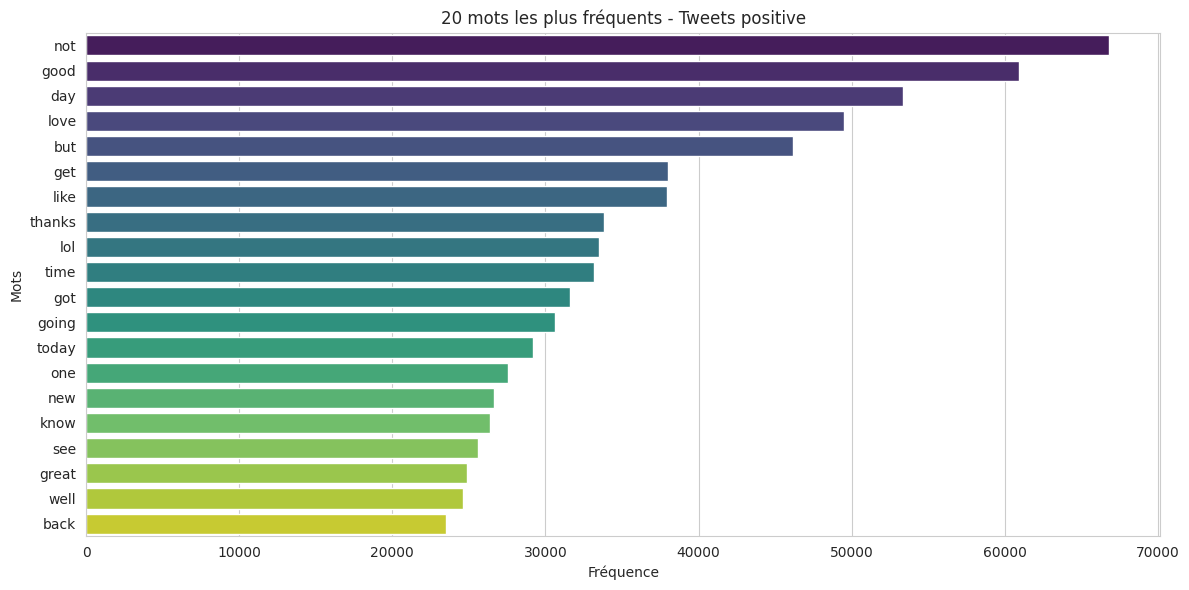

In [19]:
display_words_frequency(tweets_df)
display_words_frequency(tweets_df, 'negative')
display_words_frequency(tweets_df, 'positive')

Nous pouvons constater que certains mots comme "not" ou "good" sont présents à la fois dans les deux catégories (positif / négatif), mais nous allons les garder, car si ces mots peuvent être couplés (ex: "not good") alors nous apportons un sens supplémentaire. Cf. bigrams.

## Exportation des données nettoyées

In [20]:
tweets_df.to_parquet(OUTPUT_PATH, engine='pyarrow', index=False)

In [21]:
# del tweets_df

In [22]:
print(f"Longueur moyenne des tweets : {tweets_df['tokens_lemmatized'].apply(len).mean()}")
print(f"Longueur max des tweets : {tweets_df['tokens_lemmatized'].apply(len).max()}")

Longueur moyenne des tweets : 6.956986875
Longueur max des tweets : 33


In [24]:
# get longest tweet
tweets_df['tokens_lemmatized'].apply(len).max()

# display longest tweet
tweets_df['tokens_lemmatized'][tweets_df['tokens_lemmatized'].apply(len).idxmax()]

['ì\x96´ì°¨í\x94¼',
 'bandwidthë\x8a\x94',
 'ë¶\x84ì\x82°',
 'í\x8c\x8cì¼',
 'ì\x8b\x9cì\x8a¤í',
 '\x9cì\x84',
 'ë§\x8cë\x93\x9cë\x8a\x94ê²\x8c',
 'ì\x95\x84ë\x8b\x88ë\x8b¤ë©´',
 'ì¼ë°\x98ì¸ê³¼ë\x8a\x94',
 'ì\x98ë¯¸ê°\x80',
 'ì\x97\x86ì§\x80',
 'ì\x95\x8aë\x82\x98',
 'ì\x8b¶ì\x96´ì\x9a\x94',
 'ì\x9e\x91ì\x80',
 'ì\x97¬ë\x9f¬',
 'í\x8c\x8cì¼ë\x93¤ì´',
 'ë¹¨ë¦¬',
 'ì½í\x98\x80ì§\x80ë\x8a\x94ê²\x8c',
 'ì\x98ì\x98ê°\x80',
 'ì\x9e\x88ì\x84',
 'ë\x93¯',
 'ê·¸ë\x82\x98ì',
 '\x80ë\x82\x98',
 'ì\x9a©ë\x9f\x89',
 'ssdë\x8a\x94',
 'ê°\x80ê²©ë\x84',
 'ê°\x80ê²©ì´ê²',
 'ì§\x80ë§\x8c',
 'ì\x95\x88ì',
 '\x95ì\x84±ì\x80',
 'ì¢\x80',
 'ê±±ì',
 '\x95ë\x98ë\x8a\x94ë°ì\x9a\x94']